C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-17 18:24:37,688] A new study created in memory with name: no-name-1933b188-7277-4812-bbe0-841bbae9c8cb


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-17 18:26:56,018] Trial 0 finished with value: 0.07246310069089638 and parameters: {'iterations': 562, 'depth': 6, 'learning_rate': 0.08960785365368121, 'l2_leaf_reg': 6.387926357773329, 'subsample': 0.7468055921327309, 'min_data_in_leaf': 12, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.07246310069089638.
[I 2025-05-17 18:30:26,628] Trial 1 finished with value: 0.091246266614343 and parameters: {'iterations': 721, 'depth': 5, 'learning_rate': 0.010636066512540286, 'l2_leaf_reg': 9.72918866945795, 'subsample': 0.9497327922401265, 'min_data_in_leaf': 14, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.07246310069089638.
[I 2025-05-17 18:32:55,604] Trial 2 finished with value: 0.06980993890077339 and parameters: {'iterations': 513, 'depth': 5, 'learning_rate': 0.03647316284911211, 'l2_leaf_reg': 3.6210622617823773, 'subsample': 0.8835558684167139, 'min_data_in_leaf': 11, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.06980993890077339.
[I 20

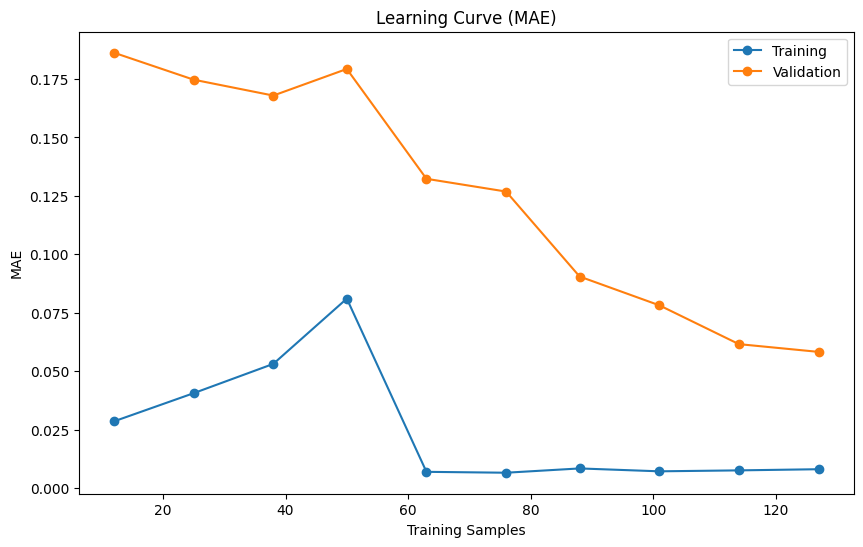

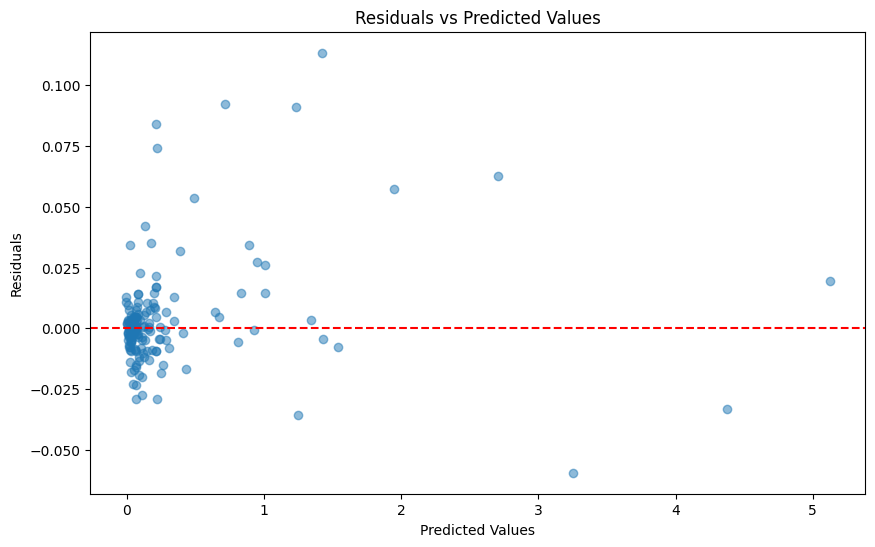

Best Parameters:
{'iterations': 966, 'depth': 6, 'learning_rate': 0.0380289049090876, 'l2_leaf_reg': 1.7939989663568956, 'subsample': 0.7034347454701829, 'min_data_in_leaf': 43, 'grow_policy': 'Depthwise'}
Best MAE: 0.0629

Final Model Evaluation:
R² Score: 0.9989
MAE: 0.0127
RMSE: 0.0223


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [2]:
import optuna
from optuna.samplers import TPESampler
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import learning_curve
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# --------------------------
# DATA PREPARATION (UNCHANGED)
# --------------------------
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)'
])
df['Raw Material'] = df['Raw Material'].str.title()

num_cols = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production', 'Raw Material', 
    'Raw Material Designation', 'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

TARGET = 'Total cost with amortization (€/part)'
X = df.drop(TARGET, axis=1)
y_original = df[TARGET].copy()
y = np.log1p(y_original)

# --------------------------
# BAYESIAN OPTIMIZATION SETUP
# --------------------------
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'
)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'depth': trial.suggest_int('depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'cat_features': list(range(len(num_cols), len(num_cols) + len(cat_cols))),
        'random_seed': 42,
        'verbose': False
    }
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    maes = []
    
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test_original = y_original.iloc[test_idx]
        
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', CatBoostRegressor(**params))
        ])
        
        model.fit(X_train, y_train)
        
        # Predict and reverse log transform
        log_y_pred = model.predict(X_test)
        y_pred = np.expm1(log_y_pred)
        
        maes.append(mean_absolute_error(y_test_original, y_pred))
    
    return np.mean(maes)

# --------------------------
# OPTIMIZATION EXECUTION
# --------------------------
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42, multivariate=True)
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

# --------------------------
# FINAL MODEL & VISUALIZATION
# --------------------------
best_params = study.best_params
best_params['cat_features'] = list(range(len(num_cols), len(num_cols) + len(cat_cols)))
best_params['verbose'] = False

final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(**best_params))
])
final_model.fit(X, y)

# Learning Curves
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -train_scores.mean(1), 'o-', label='Training')
plt.plot(train_sizes, -val_scores.mean(1), 'o-', label='Validation')
plt.title('Learning Curve (MAE)')
plt.xlabel('Training Samples')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Residual Plot
log_y_pred = final_model.predict(X)
y_pred = np.expm1(log_y_pred)
residuals = y_original - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

print("Best Parameters:")
print(study.best_params)
print(f"Best MAE: {study.best_value:.4f}")

# --------------------------
# FINAL METRICS EVALUATION
# --------------------------
mae = mean_absolute_error(y_original, y_pred)
rmse = mean_squared_error(y_original, y_pred, squared=False)
r2 = r2_score(y_original, y_pred)

print("\nFinal Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
